# Point clouds

We cover in this tutorial the instantiation and use of a `PointCloud` geometry. 

A `PointCloud` geometry holds two arrays of vectors, endowed with a cost function. Such a geometry should cover most users' needs. 

We further show differentiation through optimal transport as an example of optimization that leverages first-order gradients.

This Notebook can be run on either Jupyter Notebook or Colab (which requires running `! pip install ott-jax` first).

In [1]:
from PIL import Image
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp

import ott
from ott.geometry import pointcloud
from ott.core import sinkhorn
from ott.tools import transport

## Creates a PointCloud geometry

In [2]:
def create_points(n, m, d):
  rng = jax.random.PRNGKey(0)
  rngs = jax.random.split(rng, 3)
  x = jax.random.normal(rngs[0], (n,d)) + 1
  y = jax.random.uniform(rngs[1], (m,d))
  a = jnp.ones((n,)) / n
  b = jnp.ones((m,)) / m
  return x, y, a, b

n, m, d = 12, 14, 2
x, y, a, b = create_points(n=n, m=m, d=d)

## Computes the regularized optimal transport

To compute the transport matrix between the two point clouds, one can define a `PointCloud` geometry (which by default uses `ott.geometry.costs.Euclidean` for cost function), then call the `sinkhorn` function, and build the transport matrix from the optimized potentials.

In [3]:
geom = pointcloud.PointCloud(x, y, epsilon=1e-2)
out = sinkhorn.sinkhorn(geom, a, b)
P = geom.transport_from_potentials(out.f, out.g)

A more concise syntax to compute the optimal transport matrix is to use the `Transport` interface. Note how weights are assumed to be uniform if no parameter `a` and `b` is passed to `Transport`. 

In [4]:
ot = transport.Transport(x, y, epsilon=1e-2)

## Visualizes the transport

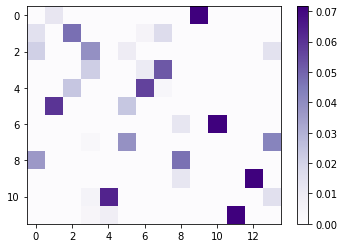

In [5]:
plt.imshow(ot.matrix, cmap='Purples')
plt.colorbar()

<AxesSubplot:>

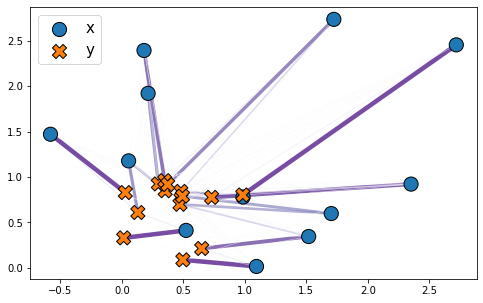

In [6]:
from ott.tools import plot
plot.couplings(ot)

## Differentiation through Optimal Transport

Our Optimal transport is implemented in a differentiable way. In the following example, we leverage the gradients to move `a` points in a way that minimizes a given cost function, which can be customized. 

It also serves as an example of using plot routines in our package.

In [7]:
import base64
import glob
import os
import shutil

from IPython import display

cost_fn_map = {
  'Euclidean': ott.geometry.costs.Euclidean,
  'Cosine': ott.geometry.costs.Cosine,
}

def infer_plot_lim(x, y, axis=0, rel_margin=0.1):
  v = jnp.concatenate([x[...,0], y[...,0]])
  min_, max_ = v.min(), v.max()
  diff = max_ - min_
  margin = diff * rel_margin
  return [min_-margin, max_+margin]

def prepare_dir(out_dir):
  os.makedirs(out_dir, exist_ok=True)
  shutil.rmtree(out_dir, ignore_errors=True)
  os.makedirs(out_dir, exist_ok=True)

def optimize(n, m, d, cost_fn_name, n_iterations, n_save_iterations, out_dir):
  n_report_iterations = 50
  learning_rate = 0.2

  x, y, a, b = create_points(n=n, m=m, d=d)

  cost_fn = cost_fn_map[cost_fn_name]()

  geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, epsilon=1e-2)
  out = sinkhorn.sinkhorn(geom, a, b)
  P = geom.transport_from_potentials(out.f, out.g)
  
  reg_ot_cost_vg = jax.value_and_grad(
    (lambda *args, **kwargs: sinkhorn.sinkhorn(*args, **kwargs).reg_ot_cost), 
    argnums=0,
  )

  plot_xlim = infer_plot_lim(x, y, axis=0)
  plot_ylim = infer_plot_lim(x, y, axis=1)
    
  image_fns = []

  for iter_ in range(0, n_iterations):
    geom = pointcloud.PointCloud(x, y, cost_fn=cost_fn, epsilon=1e-2)
    out = sinkhorn.sinkhorn(geom, a, b)
    P = geom.transport_from_potentials(out.f, out.g)
    reg_ot_cost, geom_g = reg_ot_cost_vg(geom, a, b)

    if iter_ % n_report_iterations == 0 or iter_ == n_iterations - 1:
      print(f'iter_={iter_:3d},  reg_ot_cost={reg_ot_cost:.6f}, ')
    if iter_ % n_save_iterations == 0 or iter_ == n_iterations - 1:
      
      fig, ax = plt.subplots(1, 1, figsize=(9, 6))
      ax = plot.couplings(x, y, a, b, P, ax=ax, threshold=1e-3)
      
      plt.xlim(plot_xlim)
      plt.ylim(plot_ylim)
      ax.get_legend().remove()
      image_fn = f'{out_dir}/plot_iter_{iter_:08d}.png'
      plt.savefig(image_fn, bbox_inches='tight', facecolor='white', transparent=False)
      plt.close(fig)
    
      image_fns.append(image_fn)
      
    x = x - geom_g.x * learning_rate

  return image_fns

def demo(n, m, d, cost_fn_name, n_iterations, n_save_iterations):
  out_dir = f'out/n={n}-m={m}-d={d}-cost_fn_name={cost_fn_name}'
  print(f'Resutls are saved to {out_dir}')
  prepare_dir(out_dir)
  image_fns = optimize(n, m, d, cost_fn_name, n_iterations, n_save_iterations, out_dir)
  gif_fn = f'{out_dir}/plot_animate.gif'
  plot.animate(image_fns, gif_fn)
  display.display(plot.show_gif(gif_fn))

Resutls are saved to out/n=12-m=14-d=2-cost_fn_name=Euclidean
iter_=  0,  reg_ot_cost=1.806588, 
iter_= 50,  reg_ot_cost=0.090032, 
iter_=100,  reg_ot_cost=0.031363, 



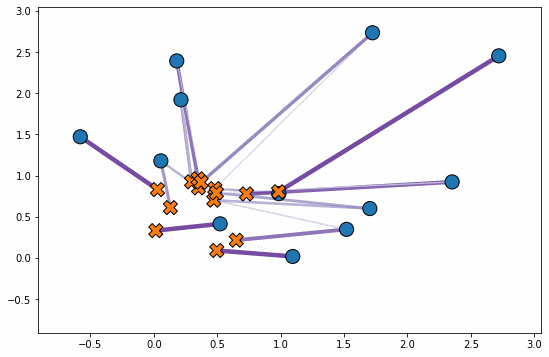

In [8]:
demo(12, 14 , 2, "Euclidean", 100+1, 10)

We could use another cost function, in this case Cosine distance, to achieve another kind of dynamics in optimization.

Resutls are saved to out/n=12-m=14-d=2-cost_fn_name=Cosine
iter_=  0,  reg_ot_cost=0.068768, 
iter_= 50,  reg_ot_cost=0.043435, 
iter_=100,  reg_ot_cost=0.033790, 
iter_=150,  reg_ot_cost=0.028240, 
iter_=200,  reg_ot_cost=0.024760, 



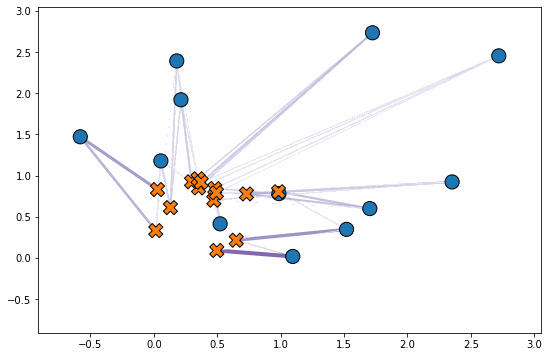

In [9]:
demo(12, 14 , 2, "Cosine", 200+1, 10)